# Historical Returns Distribution fitting

## Normal or not

Before using the Volatility infered from the log-returns normality assumption, it is worth looking into the validity of that assumption.

Plotting the returns on a histogram and overlaying the fitted Normal distribution gives an easy graphical comparison of the appropriateness of that assumption.


In [14]:

import math

import pandas as pd
# import pandas.io.sql as sqlio

import numpy as np
from numpy.random import default_rng
np.set_printoptions(precision=5, suppress=True)

import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy as scipy

import psycopg2

# import seaborn as sns

from math import log, sqrt, exp, pi
from scipy.stats import norm, laplace, t as student_t

# Markdown in code cell
from IPython.display import Markdown as md


plt.style.use('seaborn')
plt.colormaps
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

btcusd_1min = pd.read_csv("./BTCUSD.csv", sep=",", header=0, names=["date","open","high","low","close"], index_col="date")

btcusd_1min['ret_2min'] = np.log(btcusd_1min['close'] / btcusd_1min['close'].shift(2))

vol_2min = btcusd_1min['ret_2min'].std()

# number of 2-minute per year
nb_2min_per_year = 60/2 * 24 * 365.25
vol_ann = vol_2min * sqrt(nb_2min_per_year)


## Normal Distribution


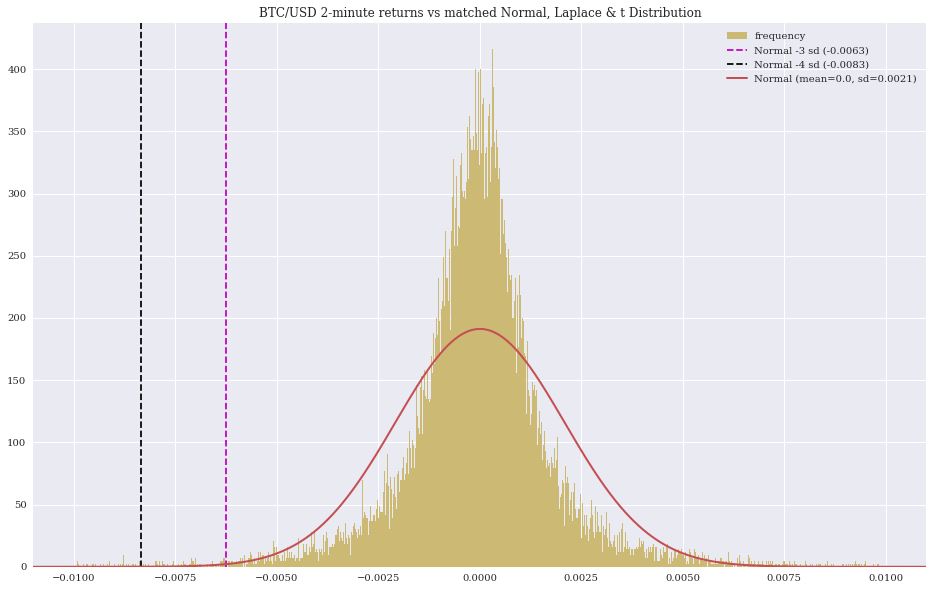

In [15]:

# nb_2min_in_30d = 30*24*60/2 # = 21600
ret_2min = btcusd_1min['ret_2min'][-21600:]
# ret_2min = btcusd_1min['ret_2min'][2:]

mean = ret_2min.mean()
std = ret_2min.std()

plt.figure(figsize=(16, 10))
plt.title("BTC/USD 2-minute returns vs matched Normal, Laplace & t Distribution")
plt.hist(ret_2min, color='C4', bins=1000, label='frequency', align='mid', density=True, range=[-0.01,0.01]);
# plt.axvline(mean + 4 * std, color='k', label='Normal +4 sd', linestyle='--')
plt.axvline(mean - 3 * std, color='m', label=f'Normal -3 sd ({(mean - 3 * std).round(4)})', linestyle='--')
plt.axvline(mean - 4 * std, color='k', label=f'Normal -4 sd ({(mean - 4 * std).round(4)})', linestyle='--')

#  Plot the Normal PDF.
m,s = norm.fit(ret_2min)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, m, s)
plt.plot(x, p, color='C2', linewidth=2, scalex=False, scaley=False, label=f"Normal (mean={m.round(4)}, sd={s.round(4)})")

# #  Plot the Laplace PDF.
# loc,scale = laplace.fit(ret_2min)
# l = laplace.pdf(x, loc, scale)
# plt.plot(x, l, color='C1', linewidth=2, scalex=False, scaley=False, label=f"Laplace (loc={loc.round(4)}, scale={scale.round(4)})")

# #  Plot the student-t PDF.
# df, tloc, tscale = student_t.fit(ret_2min)
# t = student_t.pdf(x, df, tloc, tscale)
# plt.plot(x, t, color='C3', linewidth=2, scalex=False, scaley=False, label=f"Student's t (df={df.round(2)})")

plt.legend(loc="best");
plt.show()

  

A few observations:

1. The actual returns around the mean (central peak) are much more frequent than the Normal
2. Those returns appear in a much narrower band around the mean
3. The returns outside the +/- 3-sigma band (the tails of the distribution) are hard to disthinguish

So 1. and 2. mean that there's more low amplitude returns in the data than would be if the returns were Normally distributed.

Also good to note that these are within the +/- 3-sigma range: returns between -0.63% and +0.63%.

The +/- 3-sigma range is [where 99.7% of the normal](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule) returns would be.

Given 262,980 2-minute time period per year, ~789 returns per year would be outside that range: returns smaller than -0.63% or greater than +0.63%.

So worth looking into it.

### The tails

Plotting the same histogram in logarithmic scale allows to zoom in on the tails (that and showing only the frequency increment to make it more readable.)



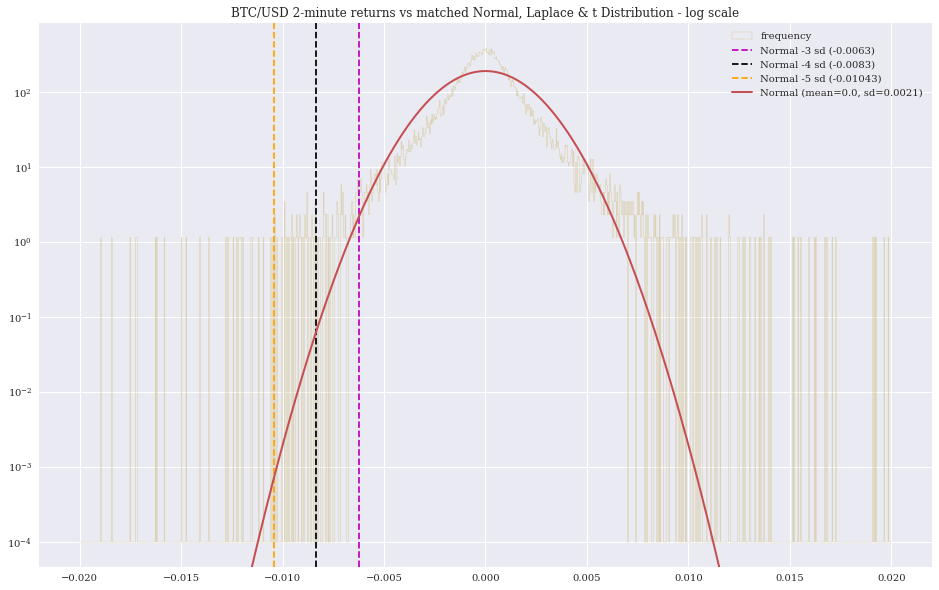

In [21]:

mean = ret_2min.mean()
std = ret_2min.std()

plt.figure(figsize=(16, 10))
# plt.figure(figsize=(24, 15))
plt.title("BTC/USD 2-minute returns vs matched Normal, Laplace & t Distribution - log scale")
plt.hist(ret_2min, color='C4', bins=1000, label='frequency', align='mid', density=True, range=[-0.02,0.02], log=True, bottom=0.0001, histtype='step');
plt.axvline(mean - 3 * std, color='m', label=f'Normal -3 sd ({(mean - 3 * std).round(4)})', linestyle='--')
plt.axvline(mean - 4 * std, color='k', label=f'Normal -4 sd ({(mean - 4 * std).round(4)})', linestyle='--')
plt.axvline(mean - 5 * std, color='orange', label=f'Normal -5 sd ({(mean - 5 * std).round(5)})', linestyle='--')

#  Plot the Normal PDF.
m,s = norm.fit(ret_2min)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, m, s)
plt.plot(x, p, color='C2', linewidth=2, scalex=False, scaley=False, label=f"Normal (mean={m.round(4)}, sd={s.round(4)})")

# #  Plot the Laplace PDF.
# loc,scale = laplace.fit(ret_2min)
# l = laplace.pdf(x, loc, scale)
# plt.plot(x, l, color='C1', linewidth=2, scalex=False, scaley=False, label=f"Laplace (loc={loc.round(4)}, scale={scale.round(4)})")

# #  Plot the student-t PDF.
# df, tloc, tscale = student_t.fit(ret_2min)
# t = student_t.pdf(x, df, tloc, tscale)
# plt.plot(x, t, color='C3', linewidth=2, scalex=False, scaley=False, label=f"Student's t (df={df.round(2)})")

plt.legend(loc='best');
plt.show()

Looking at the left tail, passed the -3-sigma dotted line, the returns are much more frequent than predicted by the Normal from ~1 to 2 orders of magnitude.

It means that extreme returns are more frequent and that volatility, as modeled by the standard deviation of normally distributed log-returns, is understated.
Also any use of that volatility, ex. for pricing an option, will be impacted.

Something that can be done about it is to look for a distribution that would better match both the central peak and the tails: the [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution).




## Laplace Distribution

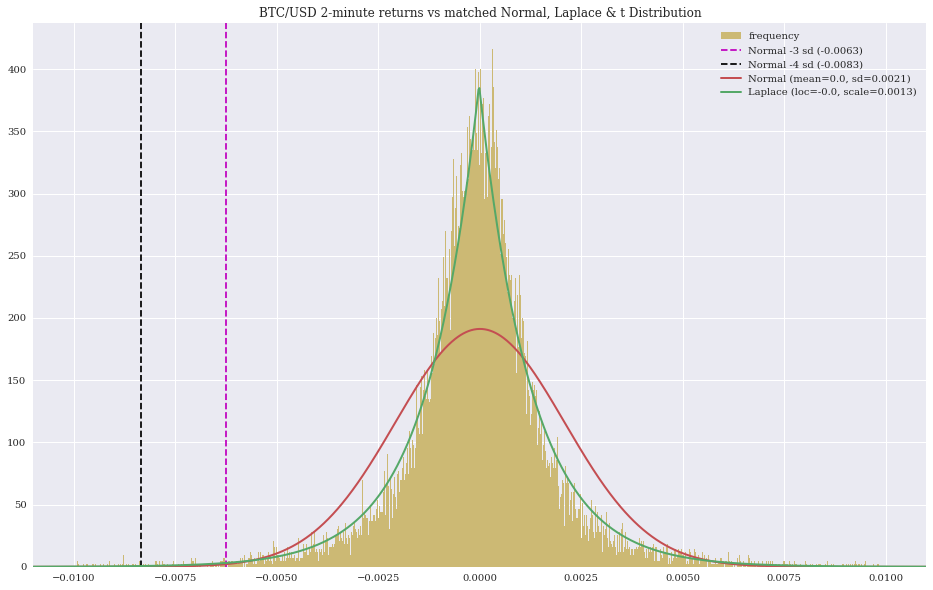

In [17]:

mean = ret_2min.mean()
std = ret_2min.std()

plt.figure(figsize=(16, 10))
plt.title("BTC/USD 2-minute returns vs matched Normal, Laplace & t Distribution")
plt.hist(ret_2min, color='C4', bins=1000, label='frequency', align='mid', density=True, range=[-0.01,0.01]);
plt.axvline(mean - 3 * std, color='m', label=f'Normal -3 sd ({(mean - 3 * std).round(4)})', linestyle='--')
plt.axvline(mean - 4 * std, color='k', label=f'Normal -4 sd ({(mean - 4 * std).round(4)})', linestyle='--')

#  Plot the Normal PDF.
m,s = norm.fit(ret_2min)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, m, s)
plt.plot(x, p, color='C2', linewidth=2, scalex=False, scaley=False, label=f"Normal (mean={m.round(4)}, sd={s.round(4)})")

#  Plot the Laplace PDF.
loc,scale = laplace.fit(ret_2min)
l = laplace.pdf(x, loc, scale)
plt.plot(x, l, color='C1', linewidth=2, scalex=False, scaley=False, label=f"Laplace (loc={loc.round(4)}, scale={scale.round(4)})")

# #  Plot the student-t PDF.
# df, tloc, tscale = student_t.fit(ret_2min)
# t = student_t.pdf(x, df, tloc, tscale)
# plt.plot(x, t, color='C3', linewidth=2, scalex=False, scaley=False, label=f"Student's t (df={df.round(2)})")

plt.legend(loc="best");
plt.show()

The Laplace distribution has two parameters, the location and the scale so similar to the normal's mean and stadard deviation.

A few observations:

1. The central peak is a better match
2. The shoulders of the peak are better matched
3. The tails are still hard to disthinguish




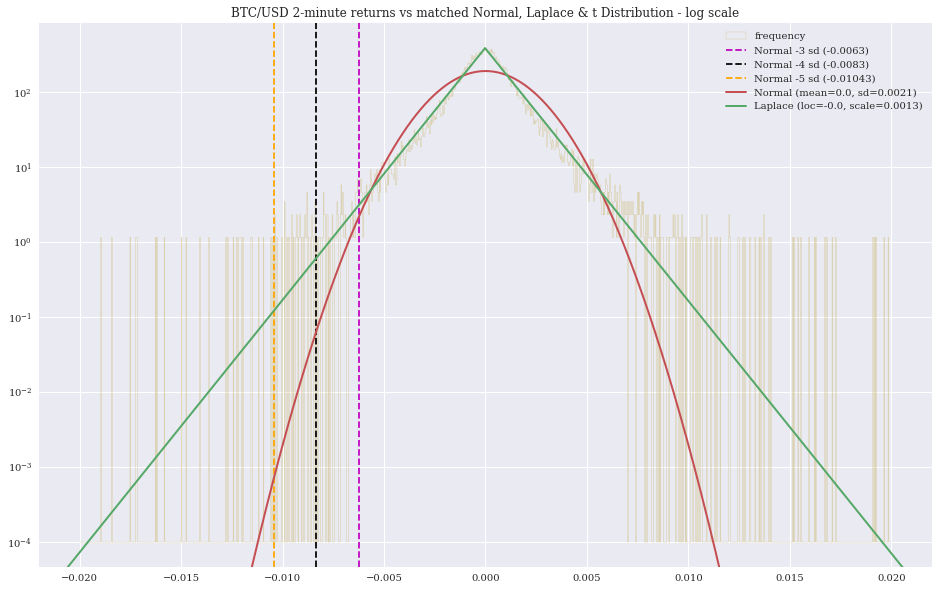

In [18]:

mean = ret_2min.mean()
std = ret_2min.std()

plt.figure(figsize=(16, 10))
# plt.figure(figsize=(24, 15))
plt.title("BTC/USD 2-minute returns vs matched Normal, Laplace & t Distribution - log scale")
plt.hist(ret_2min, color='C4', bins=1000, label='frequency', align='mid', density=True, range=[-0.02,0.02], log=True, bottom=0.0001, histtype='step');
plt.axvline(mean - 3 * std, color='m', label=f'Normal -3 sd ({(mean - 3 * std).round(4)})', linestyle='--')
plt.axvline(mean - 4 * std, color='k', label=f'Normal -4 sd ({(mean - 4 * std).round(4)})', linestyle='--')
plt.axvline(mean - 5 * std, color='orange', label=f'Normal -5 sd ({(mean - 5 * std).round(5)})', linestyle='--')

#  Plot the Normal PDF.
m,s = norm.fit(ret_2min)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, m, s)
plt.plot(x, p, color='C2', linewidth=2, scalex=False, scaley=False, label=f"Normal (mean={m.round(4)}, sd={s.round(4)})")

#  Plot the Laplace PDF.
loc,scale = laplace.fit(ret_2min)
l = laplace.pdf(x, loc, scale)
plt.plot(x, l, color='C1', linewidth=2, scalex=False, scaley=False, label=f"Laplace (loc={loc.round(4)}, scale={scale.round(4)})")

# #  Plot the student-t PDF.
# df, tloc, tscale = student_t.fit(ret_2min)
# t = student_t.pdf(x, df, tloc, tscale)
# plt.plot(x, t, color='C3', linewidth=2, scalex=False, scaley=False, label=f"Student's t (df={df.round(2)})")

plt.legend(loc='best');
plt.show()

### The tails

Looking again at the left tail, passed the -3-sigma dotted line, the returns are better predicted than the Normal.

It means that the extreme returns frequency, would be less understated than by the Normal.

Another distribution that can be looked at is the [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution).




## Student's t Distribution

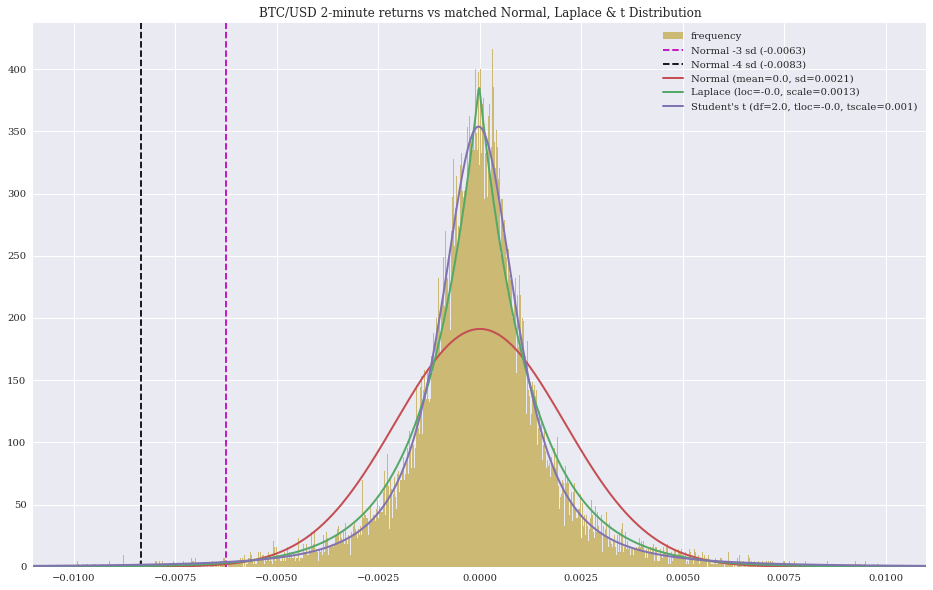

In [24]:

mean = ret_2min.mean()
std = ret_2min.std()

plt.figure(figsize=(16, 10))
plt.title("BTC/USD 2-minute returns vs matched Normal, Laplace & t Distribution")
plt.hist(ret_2min, color='C4', bins=1000, label='frequency', align='mid', density=True, range=[-0.01,0.01]);
plt.axvline(mean - 3 * std, color='m', label=f'Normal -3 sd ({(mean - 3 * std).round(4)})', linestyle='--')
plt.axvline(mean - 4 * std, color='k', label=f'Normal -4 sd ({(mean - 4 * std).round(4)})', linestyle='--')

#  Plot the Normal PDF.
m,s = norm.fit(ret_2min)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, m, s)
plt.plot(x, p, color='C2', linewidth=2, scalex=False, scaley=False, label=f"Normal (mean={m.round(4)}, sd={s.round(4)})")

#  Plot the Laplace PDF.
loc,scale = laplace.fit(ret_2min)
l = laplace.pdf(x, loc, scale)
plt.plot(x, l, color='C1', linewidth=2, scalex=False, scaley=False, label=f"Laplace (loc={loc.round(4)}, scale={scale.round(4)})")

#  Plot the student-t PDF.
df, tloc, tscale = student_t.fit(ret_2min)
t = student_t.pdf(x, df, tloc, tscale)
plt.plot(x, t, color='C3', linewidth=2, scalex=False, scaley=False, label=f"Student's t (df={df.round(2)}, tloc={tloc.round(4)}, tscale={tscale.round(4)})")

plt.legend(loc="best");
plt.show()

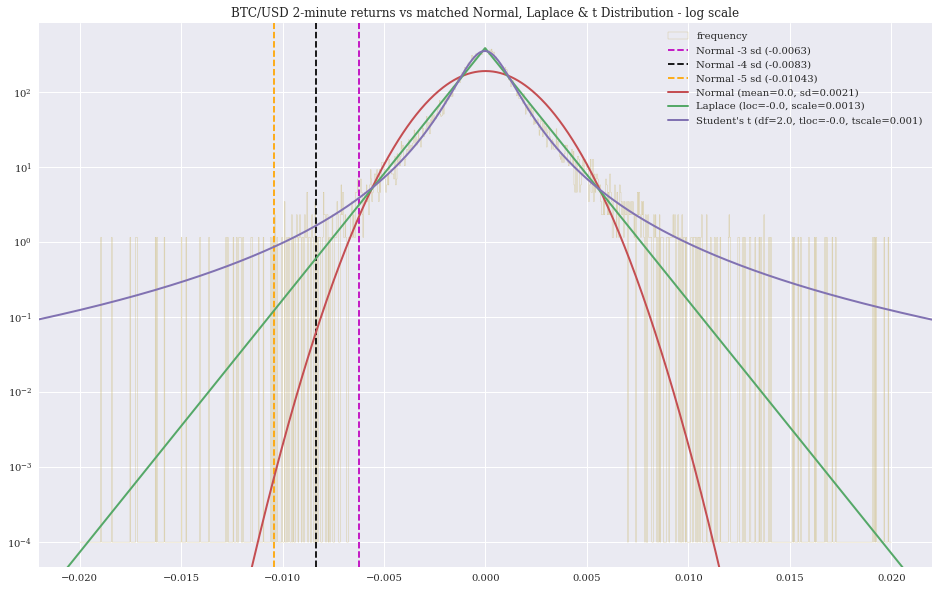

In [25]:

mean = ret_2min.mean()
std = ret_2min.std()

plt.figure(figsize=(16, 10))
plt.title("BTC/USD 2-minute returns vs matched Normal, Laplace & t Distribution - log scale")
plt.hist(ret_2min, color='C4', bins=1000, label='frequency', align='mid', density=True, range=[-0.02,0.02], log=True, bottom=0.0001, histtype='step');
plt.axvline(mean - 3 * std, color='m', label=f'Normal -3 sd ({(mean - 3 * std).round(4)})', linestyle='--')
plt.axvline(mean - 4 * std, color='k', label=f'Normal -4 sd ({(mean - 4 * std).round(4)})', linestyle='--')
plt.axvline(mean - 5 * std, color='orange', label=f'Normal -5 sd ({(mean - 5 * std).round(5)})', linestyle='--')

#  Plot the Normal PDF.
m,s = norm.fit(ret_2min)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, m, s)
plt.plot(x, p, color='C2', linewidth=2, scalex=False, scaley=False, label=f"Normal (mean={m.round(4)}, sd={s.round(4)})")

#  Plot the Laplace PDF.
loc,scale = laplace.fit(ret_2min)
l = laplace.pdf(x, loc, scale)
plt.plot(x, l, color='C1', linewidth=2, scalex=False, scaley=False, label=f"Laplace (loc={loc.round(4)}, scale={scale.round(4)})")

#  Plot the student-t PDF.
df, tloc, tscale = student_t.fit(ret_2min)
t = student_t.pdf(x, df, tloc, tscale)
plt.plot(x, t, color='C3', linewidth=2, scalex=False, scaley=False, label=f"Student's t (df={df.round(2)}, tloc={tloc.round(4)}, tscale={tscale.round(4)})")

plt.legend(loc='best');
plt.show()

## Lookback at the sigma levels

Taking a look at the _sigmal level versus frequency of events_ table previously calculated in [Historical Volatility](historical_volatility.ipynb#Volatility_interpretation_and_sigma_levels), 

but this time adding the Laplace and Student's t frequenies for comparison.

In [81]:

#
# Per year for confirmation
#


# nb_trading_day_per_year = 242

# header = '''|sigma level|%|USD|Normal frequency %|Normal days/year|Laplace frequency %|Laplace days/year|
# |:-:|-|-:|-:|-:|-:|-:|'''
# table = ""

# for i in range(1,8):
#     n = 1-(1-norm.cdf(i, 0, 1))*2
#     nn = (1-n) * nb_trading_day_per_year #
#     l = 1-(1-laplace.cdf(i, 0, 1))*2
#     ll = (1-l) * nb_trading_day_per_year
#     table += f"|{i}|{i}|{i}|{(1-n).round(9)}|{float('%.1g' % nn)}|{(1-l).round(9)}|{float('%.1g' % ll)}|\n"

# md(f"{header}\n{table}")


In [129]:

header = '''|sigma level|returns in %|returns in USD|Normal frequency %|Normal 2-min/year|Laplace frequency %|Laplace 2-min/year|t frequency %|t 2-min/year|
|:-:|-:|-:|-:|-:|-:|-:|-:|-:|'''
table = ""

for i in range(1,8):
    # norm
    n = 1-(1-norm.cdf(i, 0, 1))*2
    nn = (1-n) * nb_2min_per_year
    # laplace
    l = 1-(1-laplace.cdf(i*sqrt(2), 0, 1))*2
    ll = (1-l) * nb_2min_per_year
    # student's t
    # tsd = sqrt(df/(df-2))
    # t = 1-(1-student_t.cdf(i*tsd, df, 0, 1))*2
    t = 1-(1-student_t.cdf(i, df, 0, 1))*2
    tt = (1-t) * nb_2min_per_year
    btcusd_price = 30_000
    ret_percent = i*vol_2min*100
    ret_usd = i*vol_2min*btcusd_price
    table += f"|{i}"
    table += f"|{ret_percent.round(4)}"
    table += f"|{float('%.5g' % ret_usd)}"
    table += f"|{float('%.4g' % (1-n))}"
    table += f"|{float('%.1g' % nn)}"
    table += f"|{float('%.4g' % (1-l))}"
    table += f"|{float('%.1g' % ll)}"
    table += f"|{float('%.4g' % (1-t))}"
    table += f"|{float('%.1g' % tt)}"
    table += f"\n"

md(f"{header}\n{table}")


|sigma level|returns in %|returns in USD|Normal frequency %|Normal 2-min/year|Laplace frequency %|Laplace 2-min/year|t frequency %|t 2-min/year|
|:-:|-:|-:|-:|-:|-:|-:|-:|-:|
|1|0.2935|88.061|0.3173|80000.0|0.2431|60000.0|0.4226|100000.0
|2|0.5871|176.12|0.0455|10000.0|0.05911|20000.0|0.1835|50000.0
|3|0.8806|264.18|0.0027|700.0|0.01437|4000.0|0.09542|30000.0
|4|1.1741|352.24|6.334e-05|20.0|0.003493|900.0|0.05715|20000.0
|5|1.4677|440.3|5.733e-07|0.2|0.0008493|200.0|0.03772|10000.0
|6|1.7612|528.36|1.973e-09|0.0005|0.0002065|50.0|0.02665|7000.0
|7|2.0548|616.43|2.56e-12|7e-07|5.02e-05|10.0|0.01978|5000.0


Focusing on what should be extra-ordinary events...

At sigma level 5, the Normal predicts 2 events per 10 years,
while the Laplace predicts 200 per year.

So if the risk was expected to be Normal but got realized as Laplace in reality, it would have been understated by 1000x and likely cause trouble of that magnitude.

## Summary

- Observations on the actual log-return series distribution
    - Central peak is higher and narrower than the Normal
    - Tails are fatter (extreme events happens more frequently) than the Normal

- Observations on the data-fit Laplace distribution
    - Overall better match than the Normal
    - Defined by similar parameters as the Normal: Location & Scale

- Observations on the data-fit Laplace distribution
    - Overall better match than the Normal
    - Better match than the Laplace in the tails
    - Defined by an extra parameter: degree of freedom
    - The fitting gives a parameterized distribution with variance tending to infinity (likely not good)
